In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# 設置隨機種子以確保可重現性
torch.manual_seed(0)
np.random.seed(0)

# 數據預處理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加載數據集
dataset_path = '/content/drive/My Drive/animals'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# 劃分數據集
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed=0):
    """設置隨機種子以確保實驗的可重現性。"""
    random.seed(seed)       # Python 內置的隨機庫
    np.random.seed(seed)    # NumPy 的隨機種子
    torch.manual_seed(seed) # 為 CPU 設置 PyTorch 的隨機種子
    torch.cuda.manual_seed(seed)          # 為當前 GPU 設置種子
    torch.cuda.manual_seed_all(seed)      # 為所有 GPU 設置種子
    torch.backends.cudnn.deterministic = True  # 確保每次返回的卷積算法將是確定的，如果不設置這個，即使其他種子固定，還是可能會因為卷積算法的選擇而得到不同的結果
    torch.backends.cudnn.benchmark = False     # 如果網絡的輸入數據維度或類型上變化不大，設置 True 可以增進訓練速度，反之則應設置為 False

# 使用這個函數
set_seed(0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):  # 更改類別數為 3
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # 輸出層改為 3
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50):
    # 保存訓練和驗證的準確率歷史記錄

    train_accuracy = []
    val_accuracy = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()  # 設置模型為訓練模式

        total_train_loss, total_train_correct, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_l = total_train_loss / len(train_loader)
        train_acc = 100 * total_train_correct / total_train
        train_accuracy.append(train_acc)
        train_loss.append(train_l)

        # 驗證階段
        model.eval()  # 設置模型為評估模式

        with torch.no_grad():
            total_val_loss, total_val_correct, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_l = total_val_loss / len(val_loader)
        val_acc = 100 * total_val_correct / total_val

        val_accuracy.append(val_acc)
        val_loss.append(val_l)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_l:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_l:.4f}, Validation Accuracy: {val_acc:.2f}%')

    return train_accuracy, val_accuracy, train_loss, val_loss

In [ ]:
# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=3).to(device)  # device 已經定義為 "cuda" 或 "cpu"
criterion = torch.nn.CrossEntropyLoss()

optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)

# 假設 train_loader 和 val_loader 已經設置
print("Training with SGD")
train_accuracy_sgd, val_accuracy_sgd, train_loss_sgd, val_loss_sgd = train_model(model, train_loader, val_loader, optimizer_sgd, criterion, device, num_epochs=50)

# 重新初始化模型以避免權重重用的影響
model = AlexNet(num_classes=3).to(device)
print("Training with Adam")
train_accuracy_adam, val_accuracy_adam, train_loss_adam, val_loss_adam = train_model(model, train_loader, val_loader, optimizer_adam, criterion, device, num_epochs=50)


Training with SGD
Epoch 1/50, Train Loss: 1.0984, Train Accuracy: 33.19%, Validation Loss: 1.0982, Validation Accuracy: 33.50%
Epoch 2/50, Train Loss: 1.0982, Train Accuracy: 35.33%, Validation Loss: 1.0981, Validation Accuracy: 31.67%
Epoch 3/50, Train Loss: 1.0980, Train Accuracy: 36.00%, Validation Loss: 1.0980, Validation Accuracy: 31.33%
Epoch 4/50, Train Loss: 1.0978, Train Accuracy: 36.19%, Validation Loss: 1.0979, Validation Accuracy: 31.33%
Epoch 5/50, Train Loss: 1.0977, Train Accuracy: 37.48%, Validation Loss: 1.0978, Validation Accuracy: 31.33%
Epoch 6/50, Train Loss: 1.0976, Train Accuracy: 36.76%, Validation Loss: 1.0977, Validation Accuracy: 31.33%
Epoch 7/50, Train Loss: 1.0973, Train Accuracy: 39.24%, Validation Loss: 1.0976, Validation Accuracy: 31.83%
Epoch 8/50, Train Loss: 1.0972, Train Accuracy: 40.43%, Validation Loss: 1.0974, Validation Accuracy: 32.17%
Epoch 9/50, Train Loss: 1.0969, Train Accuracy: 43.05%, Validation Loss: 1.0973, Validation Accuracy: 34.67%
E

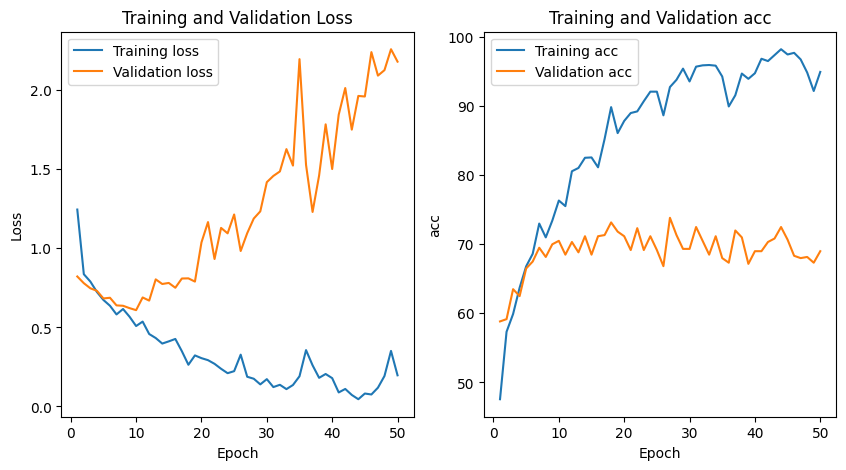

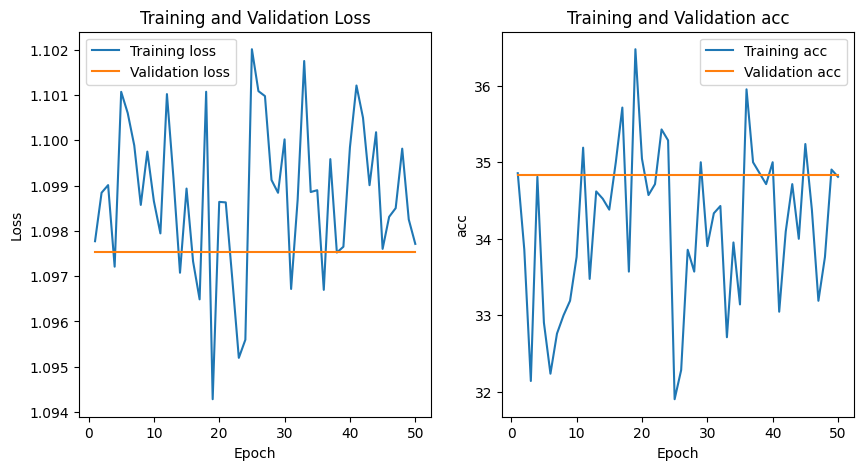

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(train_accuracy, val_accuracy, train_loss, val_loss, num_epochs, name):
  epochs = np.arange(1, num_epochs + 1)  # 生成一個從 1 到 50 的整數數組
  t_loss = np.array(train_loss)
  v_loss = np.array(val_loss)
  t_acc = np.array(train_accuracy)
  v_acc = np.array(val_accuracy)

  # 使用 matplotlib 繪圖
  plt.figure(figsize=(10, 5))  # 設定圖表大小
  plt.subplot(1, 2, 1)  # 1行2列的第1个
  plt.plot(epochs, t_loss, label='Training loss')
  plt.plot(epochs, v_loss, label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)  # 1行2列的第1个
  plt.plot(epochs, t_acc, label='Training acc')
  plt.plot(epochs, v_acc, label='Validation acc')
  plt.title('Training and Validation acc')
  plt.xlabel('Epoch')
  plt.ylabel('acc')
  plt.legend()

plot(train_accuracy_sgd, val_accuracy_sgd, train_loss_sgd, val_loss_sgd, 50, 'Alexnet with SGD')
plot(train_accuracy_adam, val_accuracy_adam, train_loss_adam, val_loss_adam, 50, 'alexnet with Adam')

In [ ]:
def evaluate_accuracy(test_loader, model, device):
    model.eval()  # 將模型設置為評估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 在這個塊中，不計算梯度
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# 使用函數
# 假設 test_loader, model 和 device 已經定義
test_accuracy = evaluate_accuracy(test_loader, model, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 32.67%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            # 第一個卷積層
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 第二個卷積層
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 第三個卷積層
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # 第一個全連接層
            nn.Dropout(),
            nn.Linear(384 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            # 第二個全連接層
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimplifiedAlexNet(num_classes=3).to(device)  # device 已經定義為 "cuda" 或 "cpu"
criterion = torch.nn.CrossEntropyLoss()

optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)

# 假設 train_loader 和 val_loader 已經設置
print("Training with SGD")
train_accuracy_sgd, val_accuracy_sgd, train_loss_sgd, val_loss_sgd = train_model(model, train_loader, val_loader, optimizer_adam, criterion, device, num_epochs=50)
test_accuracy = evaluate_accuracy(test_loader, model, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# 重新初始化模型以避免權重重用的影響
model = SimplifiedAlexNet(num_classes=3).to(device)
print("Training with Adam")
train_accuracy_adam, val_accuracy_adam, train_loss_adam, val_loss_adam = train_model(model, train_loader, val_loader, optimizer_adam, criterion, device, num_epochs=50)
test_accuracy = evaluate_accuracy(test_loader, model, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Training with SGD
Epoch 1/50, Train Loss: 1.2455, Train Accuracy: 47.57%, Validation Loss: 0.8221, Validation Accuracy: 58.83%
Epoch 2/50, Train Loss: 0.8365, Train Accuracy: 57.33%, Validation Loss: 0.7797, Validation Accuracy: 59.17%
Epoch 3/50, Train Loss: 0.7899, Train Accuracy: 59.90%, Validation Loss: 0.7473, Validation Accuracy: 63.50%
Epoch 4/50, Train Loss: 0.7243, Train Accuracy: 63.71%, Validation Loss: 0.7315, Validation Accuracy: 62.50%
Epoch 5/50, Train Loss: 0.6736, Train Accuracy: 66.81%, Validation Loss: 0.6832, Validation Accuracy: 66.50%
Epoch 6/50, Train Loss: 0.6370, Train Accuracy: 68.62%, Validation Loss: 0.6875, Validation Accuracy: 67.50%
Epoch 7/50, Train Loss: 0.5821, Train Accuracy: 73.00%, Validation Loss: 0.6393, Validation Accuracy: 69.50%
Epoch 8/50, Train Loss: 0.6164, Train Accuracy: 71.00%, Validation Loss: 0.6369, Validation Accuracy: 68.17%
Epoch 9/50, Train Loss: 0.5674, Train Accuracy: 73.43%, Validation Loss: 0.6219, Validation Accuracy: 70.00%
E

SimplifiedAlexNet with SGD
SimplifiedAlexNet with Adam


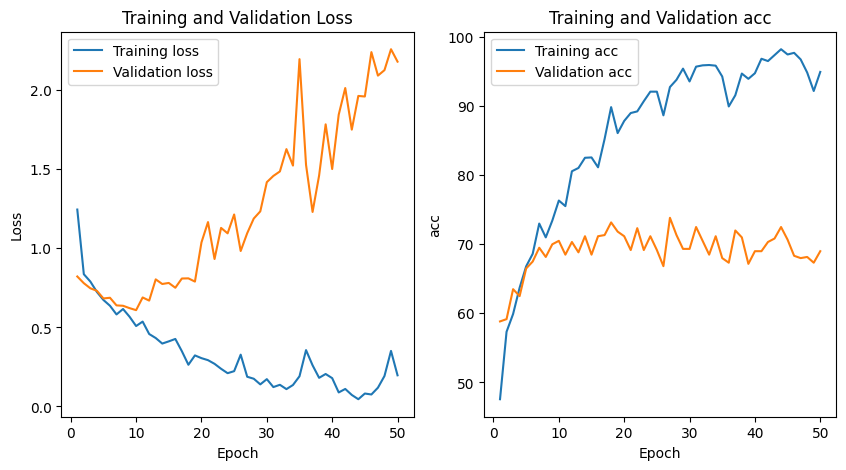

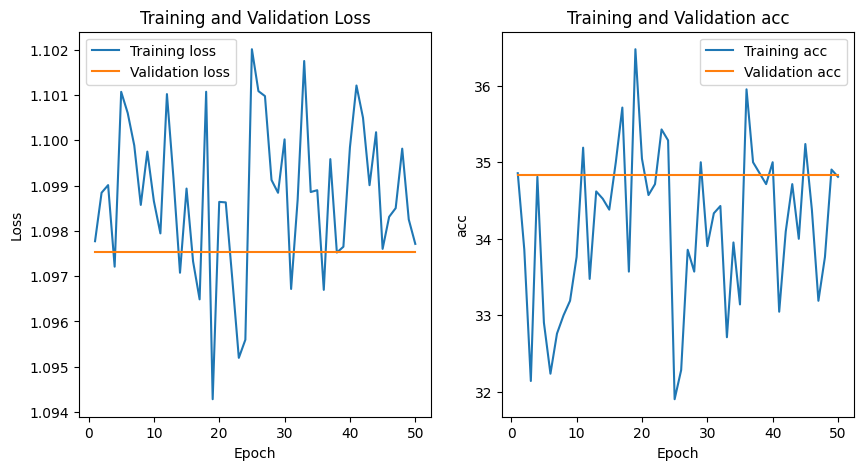

In [ ]:
print('SimplifiedAlexNet with SGD')
plot(train_accuracy_sgd, val_accuracy_sgd, train_loss_sgd, val_loss_sgd, 50, 'SimplifiedAlexNet with SGD')
print('SimplifiedAlexNet with Adam')
plot(train_accuracy_adam, val_accuracy_adam, train_loss_adam, val_loss_adam, 50, 'SimplifiedAlexNet with Adam')

In [ ]:
import torch
import torch.nn.functional as F

def train_model_with_scheduler(model, train_loader, val_loader, optimizer, criterion, device, scheduler, num_epochs=50):
    # 保存訓練和驗證的準確率歷史記錄

    train_accuracy = []
    val_accuracy = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()  # 設置模型為訓練模式

        total_train_loss, total_train_correct, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)
            scheduler.step()

        train_l = total_train_loss / len(train_loader)
        train_acc = 100 * total_train_correct / total_train
        train_accuracy.append(train_acc)
        train_loss.append(train_l)

        # 驗證階段
        model.eval()  # 設置模型為評估模式

        with torch.no_grad():
            total_val_loss, total_val_correct, total_val = 0, 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val += labels.size(0)
        val_l = total_val_loss / len(val_loader)
        val_acc = 100 * total_val_correct / total_val

        val_accuracy.append(val_acc)
        val_loss.append(val_l)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_l:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_l:.4f}, Validation Accuracy: {val_acc:.2f}%')

    return train_accuracy, val_accuracy, train_loss, val_loss

In [ ]:
from torch.optim.lr_scheduler import StepLR
# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 實例化模型並移至 GPU
model = SimplifiedAlexNet(num_classes=3).to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  # 使用SGD優化器，初始學習率設為0.1
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)  # 每30個epoch後學習率乘以0.1


print("Training with SGD")
train_accuracy_sgd_LR, val_accuracy_sgd_LR, train_loss_sgd_LR, val_loss_sgd_LR = train_model_with_scheduler(model, train_loader, val_loader, optimizer_adam, criterion, device, scheduler, num_epochs=50)
test_accuracy = evaluate_accuracy(test_loader, model, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Training with SGD
Epoch 1/50, Train Loss: 1.1018, Train Accuracy: 34.29%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 2/50, Train Loss: 1.1009, Train Accuracy: 34.14%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 3/50, Train Loss: 1.1039, Train Accuracy: 33.67%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 4/50, Train Loss: 1.1037, Train Accuracy: 33.76%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 5/50, Train Loss: 1.0992, Train Accuracy: 36.10%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 6/50, Train Loss: 1.1032, Train Accuracy: 34.86%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 7/50, Train Loss: 1.1015, Train Accuracy: 34.81%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 8/50, Train Loss: 1.1037, Train Accuracy: 34.76%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
Epoch 9/50, Train Loss: 1.1022, Train Accuracy: 34.81%, Validation Loss: 1.0989, Validation Accuracy: 31.83%
E

SimplifiedAlexNet with SGD_LR


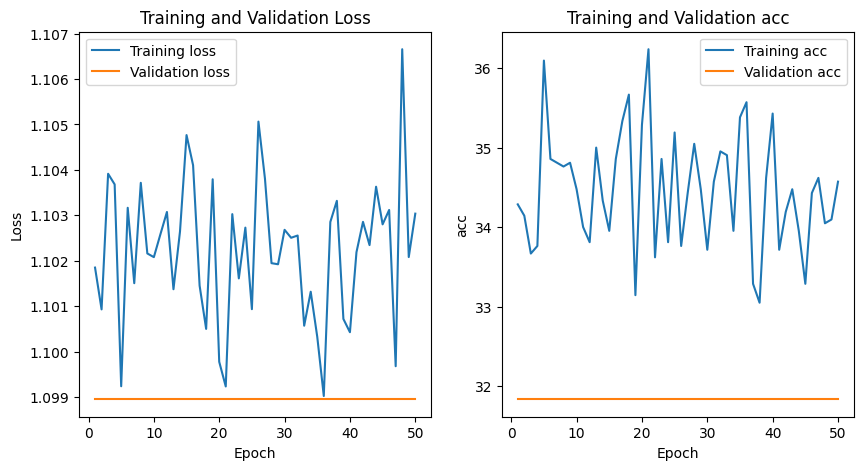

In [ ]:
print('SimplifiedAlexNet with SGD_LR')
plot(train_accuracy_sgd_LR, val_accuracy_sgd_LR, train_loss_sgd_LR, val_loss_sgd_LR, 50, 'SimplifiedAlexNet with SGD')